In [1]:
#@title Install
!pip install mujoco
!pip install mujoco_mjx
!pip install brax
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

In [2]:
#@title Check if MuJoCo installation was successful

from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [3]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [4]:
#@title Import MuJoCo, MJX, and Brax

from datetime import datetime
import functools
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Tuple, Union

from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, State
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import model
from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx


/usr/local/lib/python3.10/dist-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/usr/local/lib/python3.10/dist-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray


In [5]:
from google.colab import drive
drive.mount("Drive")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at Drive; to attempt to forcibly remount, call drive.mount("Drive", force_remount=True).


In [6]:
import functools
from datetime import datetime
from brax import envs

In [7]:
#@title Create Environment With Scaling Variables
import sys
sys.path.append('/content/Drive/MyDrive/Codes/ScalingOptimization')
import numpy as np
from env_model_generator import humanoid_genesis
from train import tRain
from HumanoidEnv import createIt
from base_env import MjxEnv
from jax import numpy as jp
from brax.envs.base import Env, State
from datetime import datetime
import functools
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Tuple, Union

from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, State
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import model
from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
import flax
from mujoco import mjx

In [8]:
#@title Progress Record
def progress_record(iteration, arr_of_x_data, arr_of_y_data, times) :
  ...
  plt.show()

In [9]:
epsilon = 0.2
init_training_state = None
num_scaling_var = 17 # Must be tuned according to the base model
init_scaling_vars = np.zeros(num_scaling_var)
N = 5
path_to_base_env = "/content/Drive/MyDrive/Codes/Data/Xml_files/humanoid.xml"
num_iterations_to_go = 500
mutation_limits_wstrt = {
    "max" : [epsilon for i in range(num_scaling_var)],
    "min" : [-epsilon for i in range(num_scaling_var)]
}
mutation_limits_explr = {
    "max" : [2*epsilon for i in range(num_scaling_var)],
    "min" : [-2*epsilon for i in range(num_scaling_var)]
}

In [10]:
#@title Humanoid
name = "init_balance"
path = humanoid_genesis([0 for i in range(num_scaling_var)], name, base_path = "/content/Drive/MyDrive/Eurekas/Eureka/eureka/XmlAssets/humanoidMJX_Balance_1.xml" )
#path = "/content/Drive/MyDrive/Codes/Data/Xml_files/Humanoid_Gen1_Robot3.xml"
class Humanoid(MjxEnv):
  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(4.8, 7.0),
      healthy_x_range=(-0.8,0.8),
      healthy_y_range=(-0.5,0.5),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,
  ):
      mj_model = mujoco.MjModel.from_xml_path(path)
      mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
      mj_model.opt.iterations = 6
      mj_model.opt.ls_iterations = 6
      physics_steps_per_control_step = 5
      kwargs['physics_steps_per_control_step'] = kwargs.get(
          'physics_steps_per_control_step', physics_steps_per_control_step)

      super().__init__(mj_model=mj_model, **kwargs)

      self._forward_reward_weight = forward_reward_weight
      self.tt_penalty = 0
      self._ctrl_cost_weight = ctrl_cost_weight
      self._healthy_reward = healthy_reward
      self._terminate_when_unhealthy = terminate_when_unhealthy
      self._healthy_x_range = healthy_x_range
      self._healthy_y_range = healthy_y_range
      self._healthy_z_range = healthy_z_range
      self._reset_noise_scale = reset_noise_scale
      self._exclude_current_positions_from_observation = (
          exclude_current_positions_from_observation
      )

  def reset(self, rng: jp.ndarray) -> State:
      """Resets the environment to an initial state."""
      rng, rng1, rng2 = jax.random.split(rng, 3)

      low, hi = -self._reset_noise_scale, self._reset_noise_scale
      qpos = self.sys.qpos0 + jax.random.uniform(
          rng1, (self.sys.nq,), minval=low, maxval=hi
      )
      qvel = jax.random.uniform(
          rng2, (self.sys.nv,), minval=low, maxval=hi
      )

      data = self.pipeline_init(qpos, qvel)

      obs = self._get_obs(data, jp.zeros(self.sys.nu))
      reward, done, zero = jp.zeros(3)
      metrics = {
          'x_reward': zero,
          'y_reward': zero,
          'z_reward': zero,
          'reward_quadctrl': zero,
          'reward_alive': zero,
          'x_position': zero,
          'y_position': zero,
          'distance_from_origin': zero,
      }
      return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
      """Runs one timestep of the environment's dynamics."""
      data0 = state.pipeline_state
      data = self.pipeline_step(data0, action)
      com_before = data0.subtree_com[3]
      com_after = data.subtree_com[3]
      self.tt_penalty += 1

      min_x, max_x = self._healthy_x_range
      min_y, max_y = self._healthy_y_range
      min_z, max_z = self._healthy_z_range

      x_reward = 1 / (abs(com_after[0] - ((min_x + max_x) / 2)) + 0.02)
      y_reward = 1 / (abs(com_after[1] - ((min_y + max_y) / 2)) + 0.02)


      z_distance = abs(com_after[2] - ((min_z + max_z) / 2))
      z_reward = 1 / (z_distance + 0.01)

      pos_reward = x_reward + y_reward + z_reward

      is_healthy = jp.where(com_after[2] < min_z, x=0.0, y=1.0)
      is_healthy = jp.where(
          com_after[2] > max_z, x=0.0, y=is_healthy
      )

      if self._terminate_when_unhealthy:
          healthy_reward = self._healthy_reward
      else:
          healthy_reward = self._healthy_reward * is_healthy

      uph_cost = (com_after[2] - 0) / self.dt
      ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))
      obs = self._get_obs(data, action)

      reward = uph_cost - ctrl_cost + 1 / 10
      done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0
      state.metrics.update(
          x_reward=x_reward,
          y_reward=y_reward,
          z_reward=z_reward,
          reward_quadctrl=-ctrl_cost,
          reward_alive=healthy_reward,
          x_position=com_after[0],
          y_position=com_after[1],
          distance_from_origin=jp.linalg.norm(com_after)
      )
      return state.replace(
          pipeline_state=data, obs=obs, reward=reward, done=done
      )
  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
      """Observes humanoid body position, velocities, and angles."""
      position = data.qpos
      if self._exclude_current_positions_from_observation:
          position = position[2:]
      # external_contact_forces are excluded
      return jp.concatenate([
          position,
          data.qvel,
          data.cinert[1:].ravel(),
          data.cvel[1:].ravel(),
          data.qfrc_actuator,
      ])

envs.register_environment(name, Humanoid)

In [11]:
with open('/usr/local/lib/python3.10/dist-packages/mujoco/gl_context.py', 'r') as f: # 'r' is a reading mode
    text = f.read()

appending = """import ctypes
import ctypes.util
ctypes.CDLL(ctypes.util.find_library('GL'), ctypes.RTLD_GLOBAL)

"""

with open('/usr/local/lib/python3.10/dist-packages/mujoco/gl_context.py', 'w') as f: # 'w' is a writing mode
    f.write(appending + text)

In [12]:
init_env = envs.get_environment(name)


jit_reset = jax.jit(init_env.reset)
jit_step = jax.jit(init_env.step)

# instantiate the renderer
%env MUJOCO_GL=egl
renderer = mujoco.Renderer(init_env.model)

/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/device.py:187: DeprecationWarning: device_put is deprecated, use put_model and put_data instead
  warnings.warn(


env: MUJOCO_GL=egl


In [13]:
#@title Define a render utility function

def get_image(state: State, camera: str) -> np.ndarray:
  """Renders the environment state."""
  d = mujoco.MjData(init_env.model)
  # write the mjx.Data into an mjData object
  mjx.device_get_into(d, state.pipeline_state)
  mujoco.mj_forward(init_env.model, d)
  # use the mjData object to update the renderer
  renderer.update_scene(d, camera=camera)
  return renderer.render()


# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state]
images = [get_image(state, camera='side')]

# grab a trajectory
for i in range(50):
  ctrl = -0.1 * jp.ones(init_env.sys.nu)
  state = jit_step(state, ctrl)
  rollout.append(state)
  images.append(get_image(state, camera='side'))

media.show_video(images, fps=1.0 / init_env.dt)

/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/device.py:250: DeprecationWarning: device_get_into is deprecated, use get_data instead
  warnings.warn(
<ipython-input-10-b391143832e6>:91: DeprecationWarning: Passing condition, x, or y to jax.numpy.where via keyword arguments is deprecated.
  is_healthy = jp.where(com_after[2] < min_z, x=0.0, y=1.0)


In [14]:
init_env = envs.get_environment (createIt(humanoid_genesis([0 for i in range(num_scaling_var)], "init"), "init"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/device.py:187: DeprecationWarning: device_put is deprecated, use put_model and put_data instead
  warnings.warn(


In [20]:
train_fn1 = functools.partial(
    tRain, num_timesteps= 10_000_000, num_evals=5, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048,
    batch_size=1024, seed=0)
train_fn2 = functools.partial(
    tRain, num_timesteps=2_000_000, num_evals=5, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048,
    batch_size=1024, seed=0)

x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 5000, 0
def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn1.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')
  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()


#make_inference_fn, params, _,ancestor_training_state = train_fn1(environment=init_env, progress_fn=progress)

#print(f'time to jit: {times[1] - times[0]}')
#print(f'time to train: {times[-1] - times[1]}')

In [21]:
@flax.struct.dataclass
class Robot :
  scaling_var: np.ndarray
  model_path: str
  brain : any

In [22]:
x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 20000, 0
def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn1.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()

In [ ]:
#@title Genetic Algorithm
name = "init"
path = humanoid_genesis([0 for i in range(num_scaling_var)], name)

init_robot = Robot(np.array([0 for i in range(num_scaling_var)]),
                   path,
                   ancestor_training_state
                   )
Candidates = [init_robot for i in range(N)]
FitnessScores = [0 for i in range(N)]
FitnessScores = np.array(FitnessScores)
Params = [0 for i in range(N)]
selected = init_robot
for i in range(num_iterations_to_go):
  print(i)
  #Sampling
  Candidates[4] = selected
  for j in range(2): # ADJUST THE HEALTHY Z RANGE, OBTAINED FROM GENESIS
      sc_var_change = np.random.uniform(mutation_limits_explr["min"], mutation_limits_explr["max"])
      new_scv = np.add(selected.scaling_var,sc_var_change)
      name=f"Humanoid_Gen{i}_Robot{j}"
      Candidates[j] = Robot(new_scv, humanoid_genesis(new_scv, name), selected.brain)
  for j in range(2):
      sc_var_change = np.random.uniform(mutation_limits_wstrt["min"], mutation_limits_wstrt["max"])
      new_scv = np.add(selected.scaling_var,sc_var_change)
      name=f"Humanoid_Gen{i}_Robot{j+2}"
      Candidates[j+2] = Robot(new_scv, humanoid_genesis(new_scv, name), selected.brain)

  #Fitness scores(perhaps can be taken from y_datas)
  for k in range(N-1):
    name=f"Humanoid_Gen{i}_Robot{k}"
    rob_env = envs.get_environment (createIt(Candidates[k].model_path, name))
    x_data = []
    y_data = []
    ydataerr = []
    times = [datetime.now()]
    print(f"\n--------\n\nIteration{i}-Robot{k}\n\n--------\n")
    make_inference_fn, Params[k], _,rob_new_training_state = train_fn2(environment=rob_env, progress_fn=progress, transfer_params=Candidates[k].brain)
    print(f'time to jit: {times[1] - times[0]}')
    print(f'time to train: {times[-1] - times[1]}')
    FitnessScores[k] = y_data[-1]
    new_rob = Robot(Candidates[k].scaling_var, Candidates[k].model_path, rob_new_training_state)
    Candidates[k] = new_rob
  #Selection and Recording
  index = np.argmax(FitnessScores)
  selected = Candidates[index]
  selected_params = Params[index]
  name = f"policy-Gen{i}"
  model_path = f'/content/Drive/MyDrive/Codes/ScalingOptimization/policies/{name}'
  model.save_params(model_path, selected_params)
  f = open("/content/Drive/MyDrive/Codes/ScalingOptimization/logofselecteds.txt", "a")
  f.write(f"{i}. Generation Model:{model_path}\n{i}. Generation Scaling Variables: {selected.scaling_var}\n")
  f.close()


  pass

0

--------

Iteration0-Robot0

--------



In [ ]:
#@title Genetic Algorithm
name = "init"
path = humanoid_genesis([0 for i in range(num_scaling_var)], name)

init_robot = Robot(np.array([0 for i in range(num_scaling_var)]),
                   path,
                   ancestor_training_state
                   )
Candidates = [init_robot for i in range(N)]
FitnessScores = [0 for i in range(N)]
FitnessScores = np.array(FitnessScores)
Params = [0 for i in range(N)]
selected = init_robot
for i in range(num_iterations_to_go):
  print(i)
  #Sampling
  Candidates[4] = selected
  for j in range(2): # ADJUST THE HEALTHY Z RANGE, OBTAINED FROM GENESIS
      sc_var_change = np.random.uniform(mutation_limits_explr["min"], mutation_limits_explr["max"])
      new_scv = np.add(selected.scaling_var,sc_var_change)
      name=f"Humanoid_Gen{i}_Robot{j}"
      Candidates[j] = Robot(new_scv, humanoid_genesis(new_scv, name), selected.brain)
  for j in range(2):
      sc_var_change = np.random.uniform(mutation_limits_wstrt["min"], mutation_limits_wstrt["max"])
      new_scv = np.add(selected.scaling_var,sc_var_change)
      name=f"Humanoid_Gen{i}_Robot{j+2}"
      Candidates[j+2] = Robot(new_scv, humanoid_genesis(new_scv, name), selected.brain)

  #Fitness scores(perhaps can be taken from y_datas)
  for k in range(N-1):
    if k > 1:

    name=f"Humanoid_Gen{i}_Robot{k}"
    rob_env = envs.get_environment (createIt(Candidates[k].model_path, name))
    x_data = []
    y_data = []
    ydataerr = []
    times = [datetime.now()]
    print(f"\n--------\n\nIteration{i}-Robot{k}\n\n--------\n")
    make_inference_fn, Params[k], _,rob_new_training_state = train_fn2(environment=rob_env, progress_fn=progress, transfer_params=Candidates[k].brain)
    print(f'time to jit: {times[1] - times[0]}')
    print(f'time to train: {times[-1] - times[1]}')
    FitnessScores[k] = y_data[-1]
    new_rob = Robot(Candidates[k].scaling_var, Candidates[k].model_path, rob_new_training_state)
    Candidates[k] = new_rob
  #Selection and Recording
  index = np.argmax(FitnessScores)
  selected = Candidates[index]
  selected_params = Params[index]
  name = f"policy-Gen{i}"
  model_path = f'/content/Drive/MyDrive/Codes/ScalingOptimization/policies/{name}'
  model.save_params(model_path, selected_params)
  f = open("/content/Drive/MyDrive/Codes/ScalingOptimization/logofselecteds.txt", "a")
  f.write(f"{i}. Generation Model:{model_path}\n{i}. Generation Scaling Variables: {selected.scaling_var}\n")
  f.close()


  pass

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/device.py:187: DeprecationWarning: device_put is deprecated, use put_model and put_data instead
  warnings.warn(


i 0

--------

Iteration0-Robot0

--------



/content/Drive/MyDrive/Codes/ScalingOptimization/HumanoidEnv.py:102: DeprecationWarning: Passing condition, x, or y to jax.numpy.where via keyword arguments is deprecated.
  is_healthy = jp.where(data.qpos[2] < min_z, x=0.0, y=1.0)


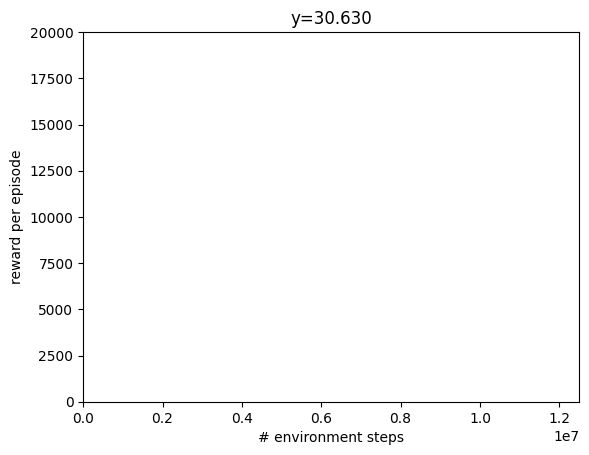

{'eval/walltime': 103.59213733673096, 'training/sps': 16433.55610362625, 'training/walltime': 159.5175130367279, 'training/entropy_loss': Array(-0.013, dtype=float32), 'training/policy_loss': Array(0.011, dtype=float32), 'training/total_loss': Array(0.11, dtype=float32), 'training/v_loss': Array(0.112, dtype=float32), 'eval/episode_distance_from_origin': Array(38.951, dtype=float32), 'eval/episode_forward_reward': Array(11.455, dtype=float32), 'eval/episode_reward': Array(202.836, dtype=float32), 'eval/episode_reward_alive': Array(215.039, dtype=float32), 'eval/episode_reward_linvel': Array(11.455, dtype=float32), 'eval/episode_reward_quadctrl': Array(-23.658, dtype=float32), 'eval/episode_x_position': Array(4.249, dtype=float32), 'eval/episode_x_velocity': Array(9.164, dtype=float32), 'eval/episode_y_position': Array(0.463, dtype=float32), 'eval/episode_y_velocity': Array(0.381, dtype=float32), 'eval/episode_distance_from_origin_std': Array(7.768, dtype=float32), 'eval/episode_forward

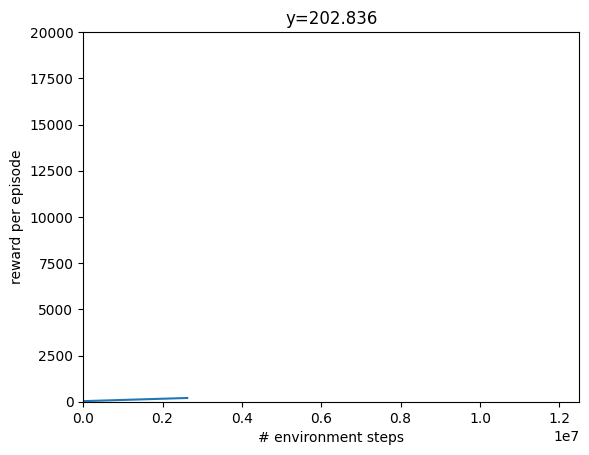

In [ ]:
#@title Genetic Algorithm
x_data = []
y_data = []
ydataerr = []

name = "init"
path = humanoid_genesis([0 for i in range(num_scaling_var)], name)

init_robot = Robot(np.array([0 for i in range(num_scaling_var)]),
                   path,
                   ancestor_training_state
                   )
Candidates = [init_robot for i in range(N)]
FitnessScores = [0 for i in range(N)]
FitnessScores = np.array(FitnessScores)
Params = [0 for i in range(N)]
selected = init_robot
for i in range(num_iterations_to_go):
  max_init_value = []
  print("i", i)
  #Sampling
  Candidates[4] = selected
  for j in range(2): # ADJUST THE HEALTHY Z RANGE, OBTAINED FROM GENESIS
      sc_var_change = np.random.uniform(mutation_limits_explr["min"], mutation_limits_explr["max"])
      new_scv = np.add(selected.scaling_var,sc_var_change)
      name=f"Humanoid_Gen{i}_Robot{j}"
      Candidates[j] = Robot(new_scv, humanoid_genesis(new_scv, name), selected.brain)
  for j in range(2):
      sc_var_change = np.random.uniform(mutation_limits_wstrt["min"], mutation_limits_wstrt["max"])
      new_scv = np.add(selected.scaling_var,sc_var_change)
      name=f"Humanoid_Gen{i}_Robot{j+2}"
      Candidates[j+2] = Robot(new_scv, humanoid_genesis(new_scv, name), selected.brain)

  #Fitness scores(perhaps can be taken from y_datas)
  for k in range(N-1):
    if i > 1:
      for k in range(N-1):
        a = 1
        rob_env = envs.get_environment (createIt(Candidates[k].model_path, name))
        times = [datetime.now()]
        print(f"\n--------\n\nIteration{i}-Robot{k}\n\n--------\n")
        make_inference_fn, Params[k], _,rob_new_training_state = train_fn2(environment=rob_env, progress_fn=progress, transfer_params=Candidates[k].brain)
        print(f'time to jit: {times[1] - times[0]}')
        print(f'time to train: {times[-1] - times[1]}')
        FitnessScores[k] = y_data[-1]
        new_rob = Robot(Candidates[k].scaling_var, Candidates[k].model_path, rob_new_training_state)
        Candidates[k] = new_rob
        a = a + 1
        if y_data[4] < max(max_init_value) / (5 - a):
          k = k + 1
        x_data = []
        y_data = []
        ydataerr = []

    else:
      pass
    name=f"Humanoid_Gen{i}_Robot{k}"
    rob_env = envs.get_environment (createIt(Candidates[k].model_path, name))
    x_data = []
    y_data = []
    ydataerr = []
    times = [datetime.now()]
    print(f"\n--------\n\nIteration{i}-Robot{k}\n\n--------\n")
    make_inference_fn, Params[k], _,rob_new_training_state = train_fn1(environment=rob_env, progress_fn=progress, transfer_params=Candidates[k].brain)
    print(f'time to jit: {times[1] - times[0]}')
    print(f'time to train: {times[-1] - times[1]}')
    FitnessScores[k] = y_data[-1]
    new_rob = Robot(Candidates[k].scaling_var, Candidates[k].model_path, rob_new_training_state)
    Candidates[k] = new_rob
    max_init_value.append(max(y_data))
  #Selection and Recording
  index = np.argmax(FitnessScores)
  selected = Candidates[index]
  selected_params = Params[index]
  name = f"policy-Gen{i}"
  model_path = f'/content/Drive/MyDrive/Codes/ScalingOptimization/policies/{name}'
  model.save_params(model_path, selected_params)
  f = open("/content/Drive/MyDrive/Codes/ScalingOptimization/logofselecteds.txt", "a")
  f.write(f"{i}. Generation Model:{model_path}\n{i}. Generation Scaling Variables: {selected.scaling_var}\n")
  f.close()


  pass

12


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#4M ts Explorer catches 5M ts Original
#3M ts WarmStarting catches 5M ts Original
#7M ts Explorer catches 10M ts Original
#6M ts Warmstarting catches 10M ts Original

In [ ]:
#@title Load Model and Define Inference Function
model_path = '/content/Drive/MyDrive/Codes/ScalingOptimization/policies/policy-Gen1'
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

In [ ]:
eval_env = envs.get_environment("init")

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/device.py:187: DeprecationWarning: device_put is deprecated, use put_model and put_data instead
  warnings.warn(


In [ ]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state]
images = [get_image(state, camera='side')]

# grab a trajectory
n_steps = 5000
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state)
  if i % render_every == 0:
    images.append(get_image(state, camera='side'))

  if state.done:
    break

media.show_video(images, fps=1.0 / eval_env.dt / render_every)